In [3]:
import numpy as np              # Import library NumPy untuk operasi numerik (array, perhitungan matematika)
import pandas as pd            # Import pandas untuk mengolah data dalam bentuk tabel (DataFrame)
import matplotlib.pyplot as plt # Import matplotlib untuk membuat grafik
import seaborn as sns          # Import seaborn untuk visualisasi data yang lebih menarik
import os                      # Import os untuk mengelola file/direktori
import warnings                # Import warnings untuk mengatur pesan peringatan
warnings.filterwarnings('ignore')  # Menonaktifkan pesan warning agar output lebih bersih

import tensorflow as tf        # Import TensorFlow sebagai framework deep learning
from tensorflow import keras   # Import modul keras yang ada di dalam TensorFlow
from tensorflow.keras import layers, models   # Import layer-layer neural network dan class model
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Untuk preprocessing gambar
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau 
# Callback: hentikan training dini, simpan model terbaik, dan turunkan learning rate otomatis

from tensorflow.keras.optimizers import Adam  # Optimizer Adam untuk training model

from sklearn.model_selection import train_test_split  # Untuk membagi dataset menjadi train/test
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
# Untuk evaluasi model seperti akurasi, confusion matrix, laporan klasifikasi

# Cek versi TensorFlow
print(f"TensorFlow version: {tf.__version__}")

# Cek apakah GPU tersedia (lebih cepat untuk training)
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Set seed agar hasil training lebih konsisten (reproducible)
np.random.seed(42)
tf.random.set_seed(42)

# Konfirmasi bahwa semua library berhasil di-import
print("\n All libraries imported successfully!")


TensorFlow version: 2.20.0
GPU Available: []

 All libraries imported successfully!


Kode tersebut berfungsi untuk menyiapkan semua library yang diperlukan sebelum membuat dan melatih model deep learning. Pertama, kode mengimpor NumPy, Pandas, Matplotlib, dan Seaborn. Library-library ini digunakan untuk mengolah data, membaca dataset, dan menampilkan grafik seperti plot akurasi atau loss. Kemudian, library os dan warnings dipakai untuk mengatur file/direktori dan menghilangkan pesan warning agar tampilan output lebih bersih.

Selanjutnya, kode mengimpor TensorFlow dan modul-modul dari Keras. Ini sangat penting karena TensorFlow merupakan mesin utama yang digunakan untuk membangun model CNN. Modul seperti layers dan models digunakan untuk menyusun arsitektur jaringan, sedangkan ImageDataGenerator dipakai untuk membaca gambar dan melakukan augmentasi agar model lebih tahan terhadap variasi data. Ada juga callback seperti EarlyStopping, ModelCheckpoint, dan ReduceLROnPlateau yang membantu proses training menjadi lebih efisien, misalnya dengan menghentikan training lebih awal jika model tidak membaik atau menurunkan learning rate secara otomatis.

Setelah itu, kode mengimpor library dari Scikit-Learn yang digunakan untuk keperluan evaluasi, seperti membuat confusion matrix atau menampilkan laporan klasifikasi. Kemudian, kode menampilkan versi TensorFlow dan mengecek apakah GPU tersedia, karena GPU membuat proses training jauh lebih cepat. Agar hasil training lebih konsisten setiap kali dijalankan, seed angka acak disetel menggunakan NumPy dan TensorFlow. Terakhir, ada pesan konfirmasi untuk memastikan semua library berhasil di-load dengan baik.

### Configuration & Parameters
Variabel seperti ukuran gambar, batch size, jumlah epoch, dan learning rate ditetapkan terlebih dahulu agar proses pelatihan berjalan konsisten. Selain itu, daftar kelas yang digunakan serta rasio pembagian dataset (training, validasi, testing) juga disiapkan. Di bagian akhir, seluruh konfigurasi dicetak ke layar sebagai ringkasan untuk memastikan pengaturan sudah benar.

In [4]:
RAW_DATASET_PATH = 'raw_dataset'       # Folder tempat dataset mentah disimpan

SELECTED_CLASSES = [                   # Daftar kelas gambar yang dipakai untuk training
    'Cassava_bacterial_blight',
    # 'Cassava_brown_streak_disease',  # (Dinonaktifkan)
    'Cassava_healthy',
    'Cassava_mosaic_disease'
]

IMG_SIZE = 224                         # Ukuran gambar input (224x224)
BATCH_SIZE = 32                        # Jumlah gambar dalam satu batch training
EPOCHS = 40                            # Total jumlah iterasi pelatihan model
LEARNING_RATE = 1e-4                   # Kecepatan pembelajaran saat update bobot model

TRAIN_RATIO = 0.7                      # Persentase data untuk training
VAL_RATIO = 0.2                        # Persentase data untuk validasi
TEST_RATIO = 0.1                       # Persentase data untuk pengujian/testing

print("="*50)                          # Cetak garis pembatas
print("CONFIGURATION SUMMARY")         # Judul ringkasan konfigurasi
print("="*50)                          # Cetak garis pembatas

print(f"Dataset Path: {RAW_DATASET_PATH}")       # Tampilkan path dataset
print(f"Selected Classes: {SELECTED_CLASSES}")   # Tampilkan daftar kelas yang dipakai
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")      # Tampilkan ukuran gambar
print(f"Batch Size: {BATCH_SIZE}")               # Tampilkan batch size
print(f"Epochs: {EPOCHS}")                       # Tampilkan jumlah epoch
print(f"Learning Rate: {LEARNING_RATE}")         # Tampilkan learning rate
print("="*50)                                    # Cetak garis pembatas terakhir


CONFIGURATION SUMMARY
Dataset Path: raw_dataset
Selected Classes: ['Cassava_bacterial_blight', 'Cassava_healthy', 'Cassava_mosaic_disease']
Image Size: 224x224
Batch Size: 32
Epochs: 40
Learning Rate: 0.0001


### Explore Dataset


DATASET EXPLORATION
 Cassava_bacterial_blight: 202 images
 Cassava_healthy: 462 images
 Cassava_mosaic_disease: 284 images
--------------------------------------------------
Total images: 948


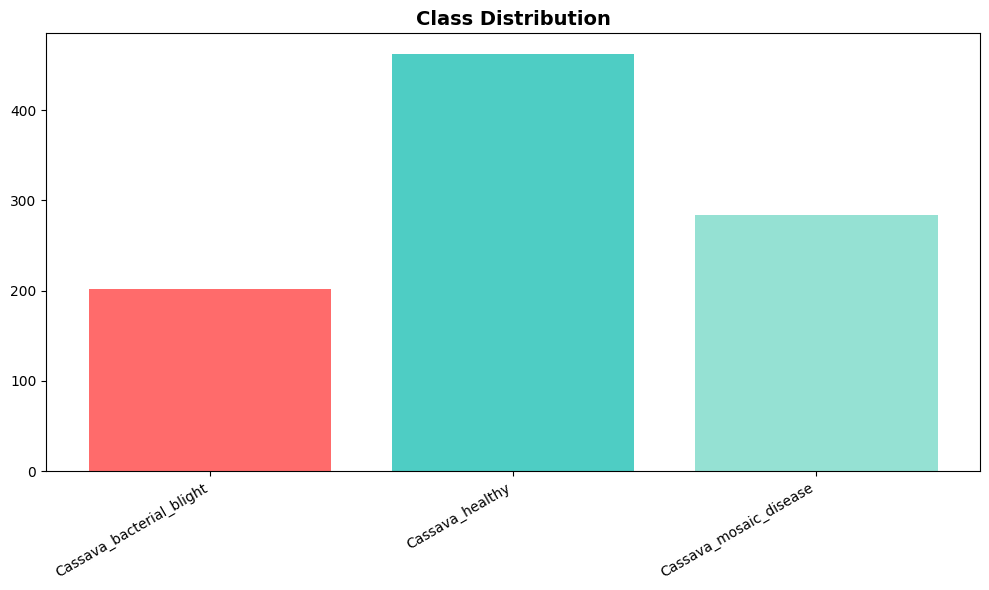

In [5]:
def explore_dataset(dataset_path, selected_classes):   # Fungsi untuk mengecek jumlah gambar per kelas
    data_info = {}                                     # Dictionary untuk menyimpan jumlah gambar tiap kelas
    total_images = 0                                   # Variabel untuk menghitung total semua gambar
    print("\nDATASET EXPLORATION")                     # Judul tampilan eksplorasi dataset
    print("="*50)
    
    for class_name in selected_classes:                # Loop untuk setiap kelas yang dipilih
        class_path = os.path.join(dataset_path, class_name)  # Gabungkan path folder utama + nama kelas
        
        if os.path.exists(class_path):                 # Cek apakah folder kelas ada
            # Hitung jumlah file gambar dalam folder (format png/jpg/jpeg)
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png','.jpg','.jpeg'))])
            data_info[class_name] = count              # Simpan jumlah gambar di dictionary
            total_images += count                      # Tambahkan ke total keseluruhan
            print(f" {class_name}: {count} images")    # Cetak jumlah gambar per kelas
        else:
            print(f" {class_path} not found!")         # Jika folder tidak ada
            data_info[class_name] = 0                  # Simpan 0 sebagai jumlah gambar kelas
    
    print("-"*50)
    print(f"Total images: {total_images}")             # Menampilkan total semua gambar
    print("="*50)
    
    return data_info, total_images                     # Kembalikan hasil perhitungan


# Menjalankan fungsi dan menyimpan hasilnya
data_info, total_images = explore_dataset(RAW_DATASET_PATH, SELECTED_CLASSES)

# Membuat grafik bar untuk distribusi jumlah gambar per kelas
plt.figure(figsize=(10,6))                             # Ukuran grafik
plt.bar(data_info.keys(), data_info.values(), 
        color=['#FF6B6B','#4ECDC4','#95E1D3','#FFD93D'])  # Warna tiap bar

plt.title("Class Distribution", fontsize=14, fontweight='bold')  # Judul grafik
plt.xticks(rotation=30, ha='right')                   # Memiringkan label agar tidak bertumpuk
plt.tight_layout()                                    # Menata layout agar rapi
plt.show()                                            # Menampilkan grafik


digunakan untuk mengecek berapa banyak gambar yang tersedia pada setiap kelas dalam dataset. Program ini akan membaca setiap folder kelas, menghitung jumlah file gambar di dalamnya, lalu menampilkan total gambarnya. Hasil perhitungan tersebut kemudian ditampilkan dalam bentuk grafik batang agar distribusi jumlah gambar per kelas dapat terlihat dengan jelas. Grafik ini membantu memastikan bahwa dataset seimbang dan siap digunakan untuk proses pelatihan model.

### Seimbangkan jumlah data


DATASET (LIMIT 100 PER CLASS)
 Cassava_bacterial_blight: 200 images (limited)
 Cassava_healthy: 200 images (limited)
 Cassava_mosaic_disease: 200 images (limited)
--------------------------------------------------
Total images (limited): 600


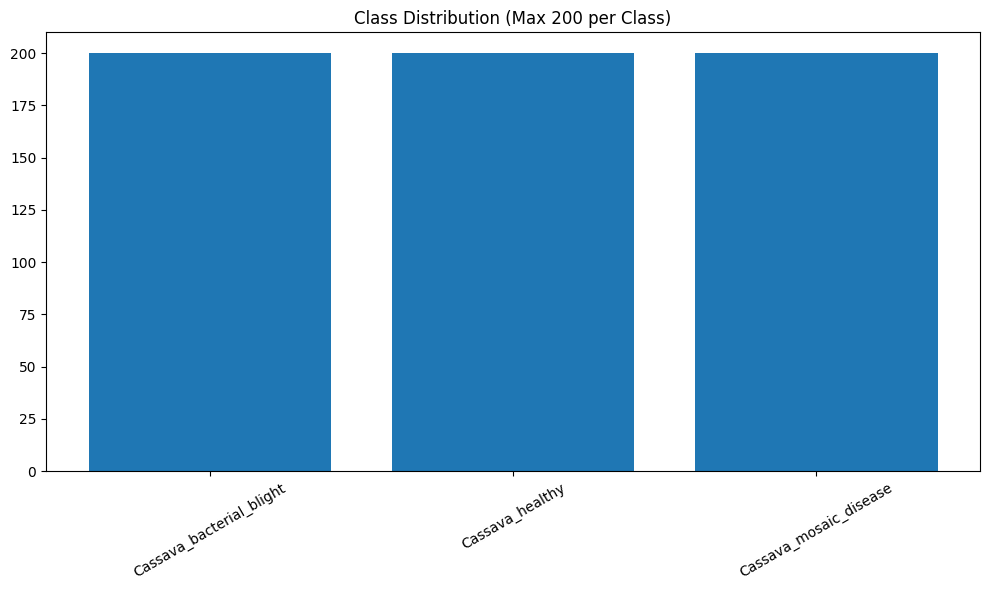

In [7]:
def explore_dataset_limit_100(dataset_path, selected_classes):   # Fungsi untuk mengecek dataset dengan batas 100 gambar per kelas
    data_info = {}                                               # Dictionary untuk menyimpan jumlah gambar tiap kelas
    total_images = 0                                             # Variabel untuk menghitung total gambar (limit)

    print("\nDATASET (LIMIT 100 PER CLASS)")                     # Judul tampilan
    print("="*50)
    
    for class_name in selected_classes:                          # Loop setiap nama kelas
        class_path = os.path.join(dataset_path, class_name)      # Gabungkan path dataset + nama kelas

        if os.path.exists(class_path):                           # Cek apakah folder kelas ada
            images = [f for f in os.listdir(class_path)          # Ambil semua file gambar
                      if f.lower().endswith(('.png','.jpg','.jpeg'))]

            limited_count = min(len(images), 200)                # Batasi maksimal 200 gambar per kelas

            data_info[class_name] = limited_count                # Simpan jumlah gambar terbatas
            total_images += limited_count                        # Tambahkan ke total keseluruhan

            print(f" {class_name}: {limited_count} images (limited)")  # Cetak jumlah gambar per kelas
        else:
            print(f" {class_path} not found!")                   # Jika folder tidak ditemukan
            data_info[class_name] = 0                            # Simpan 0

    print("-"*50)
    print(f"Total images (limited): {total_images}")             # Tampilkan total gambar terbatas
    print("="*50)

    return data_info, total_images                               # Kembalikan hasil


# Panggil fungsi untuk mendapatkan info dataset dengan limit
data_info, total_images = explore_dataset_limit_100(RAW_DATASET_PATH, SELECTED_CLASSES)

# Membuat grafik distribusi kelas
plt.figure(figsize=(10,6))                                       # Ukuran grafik
plt.bar(data_info.keys(), data_info.values())                    # Grafik batang dari jumlah gambar
plt.title("Class Distribution (Max 200 per Class)")              # Judul grafik
plt.xticks(rotation=30)                                          # Putar label agar mudah dibaca
plt.tight_layout()                                               # Atur layout agar tidak berantakan
plt.show()                                                       # Tampilkan grafik


mengecek jumlah gambar pada setiap kelas, tetapi dengan batas maksimal 200 gambar per kelas. Hal ini biasanya dilakukan jika dataset terlalu besar atau ingin mempercepat proses training. Program membaca setiap folder kelas, menghitung jumlah gambar, lalu mengambil hanya hingga 100 gambar saja. Setelah itu, jumlah gambar dari tiap kelas ditampilkan dan divisualisasikan dalam grafik batang untuk melihat apakah pembagian data sudah merata.

### Load and Prepare Data

In [8]:
def load_data(dataset_path, selected_classes):          # Fungsi untuk memuat semua file gambar dan labelnya
    paths, labels = [], []                              # List kosong untuk menyimpan path gambar dan label kelas

    for idx, cname in enumerate(selected_classes):      # Loop setiap kelas, idx = label numerik, cname = nama kelas
        cpath = os.path.join(dataset_path, cname)       # Buat path lengkap ke folder kelas

        for file in os.listdir(cpath):                  # Loop setiap file dalam folder kelas
            if file.lower().endswith(('.jpg','.png','.jpeg')):   # Ambil hanya file gambar
                paths.append(os.path.join(cpath, file))          # Simpan path gambar
                labels.append(idx)                               # Simpan label numerik sesuai indeks kelas

    return np.array(paths), np.array(labels)            # Kembalikan array path gambar dan label


# Memuat data dari dataset
X, y = load_data(RAW_DATASET_PATH, SELECTED_CLASSES)
print(f" Total Samples Loaded: {len(X)}")              # Tampilkan total gambar yang berhasil dibaca

# Membuat mapping angka → nama kelas yang lebih rapi untuk dibaca
class_names = {i: name.replace('Cassava_','').replace('_',' ').title() 
               for i,name in enumerate(SELECTED_CLASSES)}

print("\nClass Mapping:")                               # Cetak nama kelas yang sudah dirapikan
print(class_names)


 Total Samples Loaded: 948

Class Mapping:
{0: 'Bacterial Blight', 1: 'Healthy', 2: 'Mosaic Disease'}


membaca semua gambar dari tiap kelas dalam dataset dan menyimpan path gambar beserta label kelasnya. Setiap kelas diberi label angka berdasarkan urutan dalam list SELECTED_CLASSES. Setelah semua path dan label dikumpulkan, hasilnya dikembalikan sebagai array. Program kemudian menampilkan jumlah total gambar yang berhasil dimuat, dan membuat mapping nama kelas agar lebih mudah dibaca, misalnya dari "Cassava_mosaic_disease" menjadi "Mosaic Disease".

### Split Data 

In [9]:
# Membagi dataset menjadi data sementara (X_temp) dan data test (X_test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=TEST_RATIO,            # Menggunakan rasio test yang sudah ditentukan (misal 10%)
    stratify=y,                      # Agar proporsi kelas tetap seimbang
    random_state=42                  # Seed acak supaya hasilnya konsisten
)

# Menghitung rasio validasi relatif terhadap gabungan train + val
# Contoh: val=0.2, train=0.7 → val relatif = 0.2 / (0.7+0.2) = 0.2222
val_size_relative = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)

# Membagi data sementara menjadi train dan validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_size_relative,     # Rasio validasi dihitung agar hasil akhirnya pas 70/20/10
    stratify=y_temp,                 # Menjaga keseimbangan kelas
    random_state=42                  # Konsistensi split
)

# Menampilkan jumlah data untuk masing-masing bagian
print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")


Train: 663 | Val: 190 | Test: 95


membagi dataset menjadi tiga bagian: training, validation, dan testing. Pembagian dilakukan bertahap untuk memastikan rasio akhir sesuai, misalnya 70% untuk training, 20% untuk validation, dan 10% untuk testing. Fungsi train_test_split juga memakai stratify, sehingga jumlah gambar pada setiap kelas tetap seimbang. Setelah proses pembagian selesai, program menampilkan jumlah data pada setiap subset.

### Data Augmentation Setup

In [10]:
# ImageDataGenerator untuk data training (augmentasi lengkap)
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Normalisasi pixel
    rotation_range=25,              # Rotation diperkuat dari 10 → 25
    width_shift_range=0.15,         # Shift diperkuat dari 0.1 → 0.15
    height_shift_range=0.15,        # Sama seperti width shift
    zoom_range=0.2,                 # Zoom lebih besar dari 0.1 → 0.2
    shear_range=0.1,                # Tambahan shear sesuai permintaan
    brightness_range=[0.7, 1.3],    # Tambahan augmentasi brightness
    horizontal_flip=True            # Dipertahankan
)

# ImageDataGenerator untuk validation dan test (tanpa augmentasi)
val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Fungsi helper membuat DataFrame untuk flow_from_dataframe
def create_dataframe(paths, labels):
    return pd.DataFrame({
        'filename': paths,
        'class': labels.astype(str)
    })

# Membuat dataframe untuk train, val, test
train_df = create_dataframe(X_train, y_train)
val_df = create_dataframe(X_val, y_val)
test_df = create_dataframe(X_test, y_test)


menyiapkan generator gambar yang akan digunakan saat training dan evaluasi model. Pada data training, digunakan augmentasi seperti rotasi, geser posisi, zoom, dan flip agar model lebih kuat terhadap variasi gambar. Pada data validasi dan testing, hanya dilakukan normalisasi tanpa augmentasi. Kemudian, sebuah dataframe dibuat untuk menyimpan path gambar dan label kelasnya. Format dataframe ini diperlukan agar Keras dapat membaca dataset dengan lebih mudah saat proses training berlangsung.

### Create Data Generators

In [11]:
# Generator untuk data training (dengan augmentasi & acak)
train_gen = train_datagen.flow_from_dataframe(
    train_df,                                # Dataframe berisi path gambar & label
    x_col='filename',                         # Kolom yang berisi path gambar
    y_col='class',                            # Kolom label kelas
    target_size=(IMG_SIZE, IMG_SIZE),         # Ukuran gambar setelah resize
    batch_size=BATCH_SIZE,                    # Jumlah gambar per batch
    class_mode='sparse',                      # Label berupa angka (0,1,2,...)
    shuffle=True                              # Data training diacak
)

# Generator untuk data validasi (tanpa augmentasi, tidak diacak)
val_gen = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False                             # Tidak perlu acak untuk validasi
)

# Generator untuk data testing (tanpa augmentasi, tidak diacak)
test_gen = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False                             # Testing harus urut supaya dapat dievaluasi
)


Found 663 validated image filenames belonging to 3 classes.
Found 190 validated image filenames belonging to 3 classes.
Found 95 validated image filenames belonging to 3 classes.


Bagian ini membuat tiga generator gambar: satu untuk training, satu untuk validasi, dan satu untuk testing. Generator ini akan membaca gambar dari dataframe, melakukan resize, normalisasi, dan menyiapkan batch untuk training model. Pada data training, gambar diacak dan menggunakan augmentasi; sedangkan pada validasi dan testing tidak menggunakan augmentasi dan tidak diacak agar hasil evaluasi lebih stabil dan akurat.

### Visualize Sample Images

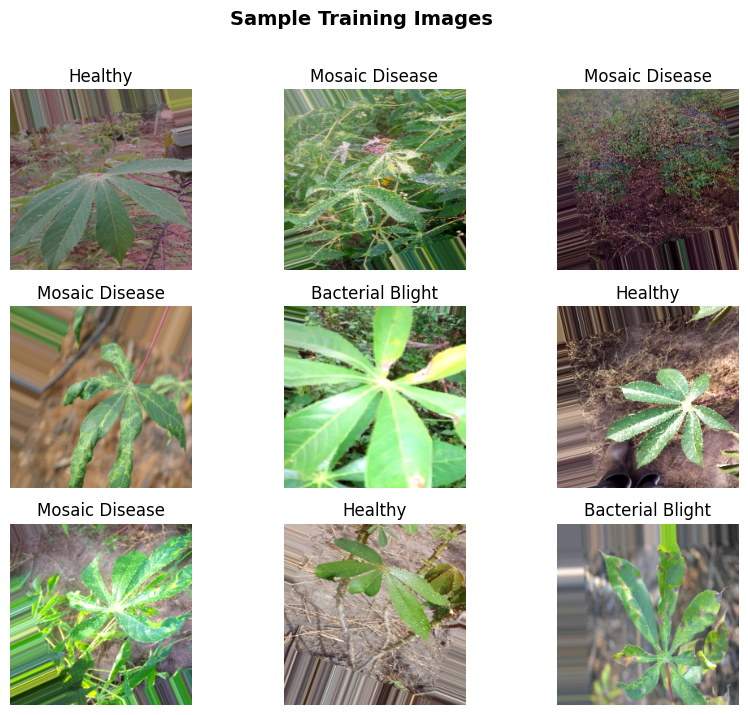

In [12]:
# Ambil satu batch gambar dari train_gen
sample_imgs, sample_labels = next(train_gen)

# Atur ukuran figure untuk tampilan grid 3x3
plt.figure(figsize=(10,8))

# Loop untuk menampilkan 9 gambar pertama dari batch
for i in range(9):
    plt.subplot(3,3,i+1)                 # Membuat grid 3x3
    plt.imshow(sample_imgs[i])           # Menampilkan gambar ke-i
    plt.title(class_names[int(sample_labels[i])])  # Judul = nama kelas
    plt.axis('off')                      # Hilangkan axis agar bersih

# Judul besar untuk keseluruhan grid
plt.suptitle("Sample Training Images", fontsize=14, fontweight='bold')

# Tampilkan plot
plt.show()


### Build Build Transfer Learning Model

In [13]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Semua layer MobileNetV2 ikut dilatih
base_model.trainable = True


# Bangun model utama
model = models.Sequential([
    base_model,

    # Mengubah feature map menjadi 1D
    layers.GlobalAveragePooling2D(),

    # Dense dengan regularisasi L2 (bantu cegah overfitting)
    layers.Dense(
        256,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),

    # Dropout untuk menambah generalisasi
    layers.Dropout(0.4),

    # Output layer sesuai jumlah kelas
    layers.Dense(
        len(SELECTED_CLASSES),
        activation='softmax'
    )
])

# Optimizer dengan LR lebih kecil agar stabil
model.compile(
    optimizer=Adam(learning_rate=1e-5),   # LR diperbaiki → stabil untuk train full backbone
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(" Model built with MobileNetV2 backbone (full-trainable, improved)!")

# Tampilkan arsitektur model
model.summary()


 Model built with MobileNetV2 backbone (full-trainable, improved)!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,691 (9.87 MB)

 Trainable params: 2,552,579 (9.74 MB)

 Non-trainable params: 34,112 (133.25 KB)

Pada bagian awal, MobileNetV2 menghasilkan output berbentuk feature map berukuran 7×7 dengan 1280 kanal. Seluruh parameter MobileNetV2 berjumlah sekitar 2,25 juta dan statusnya dibekukan (non-trainable), sehingga tidak ikut dilatih pada tahap awal training. Setelah feature map tersebut diringkas menggunakan GlobalAveragePooling2D menjadi vektor berukuran 1280, model menambahkan Dense layer berisi 256 neuron dengan sekitar 327 ribu parameter yang dapat dilatih. Kemudian terdapat Dropout 40% untuk mengurangi overfitting, diikuti layer Dense terakhir dengan 3 output sebagai prediksi kelas. Secara keseluruhan model memiliki sekitar 2,58 juta parameter, namun hanya sekitar 328 ribu yang bersifat trainable. Ini berarti model memanfaatkan MobileNetV2 sebagai ekstraktor fitur tetap, sementara bagian atasnya saja yang belajar menyesuaikan dengan dataset cassava-mu.

### Setup Callbacks

In [14]:
os.makedirs("models", exist_ok=True)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "models/best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    patience=3,
    factor=0.5,
    verbose=1
)

callbacks = [early_stopping, checkpoint, reduce_lr]


### Train the Model

In [15]:
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining selesai! Model terbaik tersimpan.")

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4510 - loss: 1.6949
Epoch 1: val_accuracy improved from None to 0.47895, saving model to models/best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 243s 9s/step - accuracy: 0.4510 - loss: 1.6606 - val_accuracy: 0.4789 - val_loss: 1.6336 - learning_rate: 1.0000e-05
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5093 - loss: 1.4939
Epoch 2: val_accuracy improved from 0.47895 to 0.50526, saving model to models/best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 184s 9s/step - accuracy: 0.5173 - loss: 1.4609 - val_accuracy: 0.5053 - val_loss: 1.5218 - learning_rate: 1.0000e-05
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5636 - loss: 1.3794
Epoch 3: val_accuracy improved from 0.50526 to 0.53684, saving model to models/best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 166s 8s/step - accuracy: 0.5656 - loss: 1.3538 - val_accuracy: 0.5368 - val_loss: 1.4420 - learning_rate: 1.0000e-05
Epoch 4/100
21/21 ━━━━━━━━━━━━━

### Plot Training History

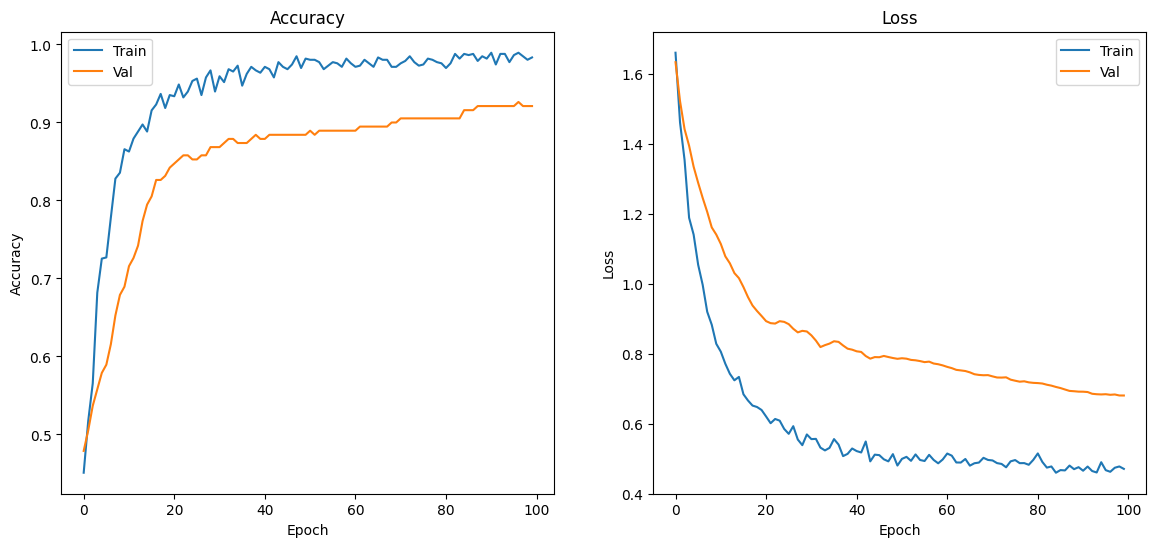

In [16]:
def plot_history(histories):
    plt.figure(figsize=(14,6))
    
    acc = histories.history['accuracy']
    val_acc = histories.history['val_accuracy']
    loss = histories.history['loss']
    val_loss = histories.history['val_loss']

    # ----------------------
    # Plot Accuracy
    # ----------------------
    plt.subplot(1,2,1)
    plt.plot(acc, label='Train')
    plt.plot(val_acc, label='Val')
    plt.title('Accuracy')
    plt.xlabel('Epoch')          # Sumbu X
    plt.ylabel('Accuracy')       # Sumbu Y
    plt.legend()

    # ----------------------
    # Plot Loss
    # ----------------------
    plt.subplot(1,2,2)
    plt.plot(loss, label='Train')
    plt.plot(val_loss, label='Val')
    plt.title('Loss')
    plt.xlabel('Epoch')          # Sumbu X
    plt.ylabel('Loss')           # Sumbu Y
    plt.legend()

    plt.show()

# Menampilkan grafik
plot_history(history)

### Evaluate

In [17]:
best_model = keras.models.load_model("models/best_model.keras")
test_loss, test_acc = best_model.evaluate(test_gen, verbose=1)

print(f"\n Test Accuracy: {test_acc*100:.2f}% | Test Loss: {test_loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9789 - loss: 0.4630  

 Test Accuracy: 97.89% | Test Loss: 0.4630


### Confusion Matrix

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step  


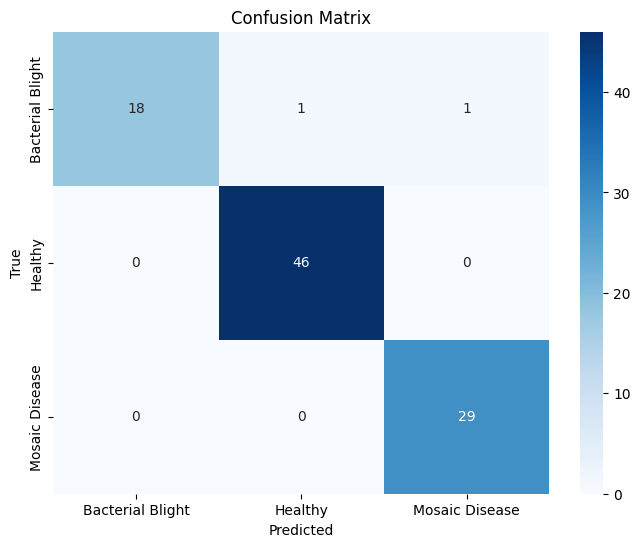

In [18]:
y_pred = np.argmax(best_model.predict(test_gen), axis=1)
y_true = test_gen.classes
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=[class_names[i] for i in range(len(SELECTED_CLASSES))],
            yticklabels=[class_names[i] for i in range(len(SELECTED_CLASSES))],
            cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Classification Report

In [19]:
print(classification_report(y_true, y_pred,
      target_names=[class_names[i] for i in range(len(SELECTED_CLASSES))],
      digits=4))

                  precision    recall  f1-score   support

Bacterial Blight     1.0000    0.9000    0.9474        20
         Healthy     0.9787    1.0000    0.9892        46
  Mosaic Disease     0.9667    1.0000    0.9831        29

        accuracy                         0.9789        95
       macro avg     0.9818    0.9667    0.9732        95
    weighted avg     0.9795    0.9789    0.9785        95



###  User Upload & Prediction

In [20]:
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load model
best_model = keras.models.load_model("models/best_model.keras")

# Daftar class
class_names = [
    "Cassava_bacterial_blight",
    # "Cassava_brown_streak_disease",
    "Cassava_healthy",
    "Cassava_mosaic_disease"
]

IMG_SIZE = (224, 224)
THRESHOLD = 50  # minimum kepercayaan model (%)
GREEN_RATIO_MIN = 0.30  # minimal proporsi warna hijau

# Widget upload
upload_widget = widgets.FileUpload(accept='.jpg,.jpeg,.png', multiple=False)
predict_button = widgets.Button(description='Predict', button_style='success')
output = widgets.Output()

def is_leaf_like(img):
    """Cek apakah gambar didominasi warna hijau."""
    img_np = np.array(img.resize((128, 128)))  # perkecil biar cepat
    r, g, b = img_np[:,:,0], img_np[:,:,1], img_np[:,:,2]
    green_pixels = np.sum((g > r + 20) & (g > b + 20))
    ratio = green_pixels / (128 * 128)
    return ratio > GREEN_RATIO_MIN, ratio

def on_predict_clicked(b):
    with output:
        clear_output()
        if not upload_widget.value:
            print(" Harap upload gambar terlebih dahulu.")
            return

        uploaded_files = upload_widget.value
        file_info = list(uploaded_files.values())[0] if isinstance(uploaded_files, dict) else uploaded_files[0]

        try:
            img_bytes = file_info['content']
            img = Image.open(io.BytesIO(img_bytes)).convert('RGB')

            # Cek dominasi warna hijau
            leaf_like, green_ratio = is_leaf_like(img)
            if not leaf_like:
                print(f" Gambar tidak didominasi warna hijau (green ratio={green_ratio:.2f}).")
                print("   Kemungkinan besar ini bukan daun singkong.")
                plt.imshow(img)
                plt.title("Bukan daun singkong")
                plt.axis('off')
                plt.show()
                return

            # Preprocessing & prediksi
            img_resized = img.resize(IMG_SIZE)
            img_array = image.img_to_array(img_resized) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            pred = best_model.predict(img_array)
            pred_class = int(np.argmax(pred, axis=1)[0])
            confidence = float(np.max(pred)) * 100

            if confidence < THRESHOLD:
                print(f" Model tidak yakin hasilnya (confidence={confidence:.2f}%).")
                print("   Kemungkinan bukan daun singkong.")
                plt.imshow(img)
                plt.title("Tidak dikenali dengan pasti")
                plt.axis('off')
                plt.show()
                return

            # Jika lolos dua tahap → tampilkan hasil
            plt.imshow(img)
            plt.title(f"{class_names[pred_class]} ({confidence:.2f}%)")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(" Terjadi kesalahan saat memproses gambar.")
            print("Detail error:", str(e))

predict_button.on_click(on_predict_clicked)
display(upload_widget, predict_button, output)


FileUpload(value=(), accept='.jpg,.jpeg,.png', description='Upload')

Button(button_style='success', description='Predict', style=ButtonStyle())

Output()

Save Model

In [21]:
import tensorflow as tf  # <— tambahkan ini

# Simpan ulang model jika belum
best_model.save("models/cassava_disease_classifier_final.keras")
print(" Saved final model!")

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]  # optional, untuk kompresi
tflite_model = converter.convert()

# Simpan file .tflite
with open("models/cassava_disease_classifier_final.tflite", "wb") as f:
    f.write(tflite_model)

print(" Model berhasil dikonversi ke TFLite!")


 Saved final model!
INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmp60uoa6i4\assets


INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmp60uoa6i4\assets


Saved artifact at 'C:\Users\ACER\AppData\Local\Temp\tmp60uoa6i4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2718601332336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2718601342896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2718601345008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2718601338320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2718601340608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2718601336912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2718601369152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2718601372672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2718601368976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2718601371440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  27186